# 任务目标
输入一张待处理的人像+想要编辑的属性（**性别**）信息，输出一张编辑后的人像。

# 初步建模
通过StyleGAN论文可知，在图中StyleGAN可以对一组向量（Z）进行分解，然后将分解后的风格向量（W）进行更加详细的拆分（W -> A1, A2, ...），最终经过多次上采样后生成出一张看似极其真实的人像数据。

换句话来说，就是给出一组随机的向量，然后StyleGAN就能生成出一个随机的人像数据。

<img src="imgs/2.png" >

## 问题
但是StyleGAN的输入是一个向量：[N, D*]，而我们的任务是`图片[N, C, H, W]`->`图片[N, C, H, W]`

**问题转化**

如果我们能从图片中获取能够控制属性的向量（隐藏因子），那么就能控制生成网络生成想要的图片了

<img src="imgs/1.png" >

## 提取隐藏因子
提取隐藏因子有很多种方法，常见的有：

- 用模型训练，拟合出指定图片的隐藏因子，本实验使用
- pixel2style2pixel，参考资料[论文笔记--pixel2style2pixel](https://zhuanlan.zhihu.com/p/267834502)



# 数据准备

如果是在恒源云，执行一下操作，避免重新下载数据集：
```
mkdir -p ～/Datasets/MNIST/MNIST/raw
cp /hy-public/MNIST/* ～/Datasets/MNIST/MNIST/raw
```


# 任务一
完成一个基础的MNIST对抗网络模型，使其可以通过一组随机向量来生成一张随机的手写数字图像。 可借助基础的DCGAN结构，训练出一组用于MNIST数据集的生成器、判别器模型。

目的：掌握GAN的基础玩法。

Acc: T [[[0.5292578]]] F [[[0.18863733]]]
Epoch_id: 0 Batch id: 0 	Loss: T  0.8366717 F 1.9051158


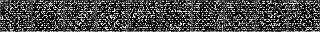

Acc: T [[[0.00764602]]] F [[[1.1771537e-05]]]
Epoch_id: 0 Batch id: 400 	Loss: T  0.007997993 F 11.49578


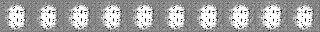

Acc: T [[[0.03035629]]] F [[[0.00148533]]]
Epoch_id: 1 Batch id: 0 	Loss: T  0.039470103 F 7.005256


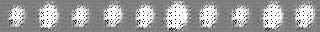

Acc: T [[[0.01978958]]] F [[[0.01384776]]]
Epoch_id: 1 Batch id: 400 	Loss: T  0.022566555 F 4.573867


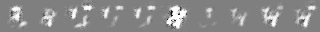

Acc: T [[[0.00360525]]] F [[[0.00506391]]]
Epoch_id: 2 Batch id: 0 	Loss: T  0.0036308856 F 5.7975836


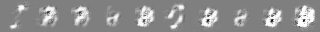

Acc: T [[[0.0201984]]] F [[[0.0141296]]]
Epoch_id: 2 Batch id: 400 	Loss: T  0.02127426 F 5.0807047


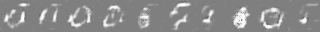

Acc: T [[[0.00498903]]] F [[[0.01446499]]]
Epoch_id: 3 Batch id: 0 	Loss: T  0.0050749495 F 4.907465


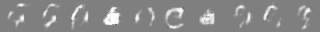

Acc: T [[[0.01880318]]] F [[[0.00139004]]]
Epoch_id: 3 Batch id: 400 	Loss: T  0.025897734 F 7.19256


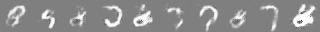

Acc: T [[[0.06592381]]] F [[[0.01923698]]]
Epoch_id: 4 Batch id: 0 	Loss: T  0.07853827 F 5.1599874


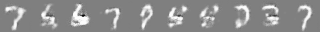

Acc: T [[[0.0198341]]] F [[[0.00958171]]]
Epoch_id: 4 Batch id: 400 	Loss: T  0.02410069 F 5.634919


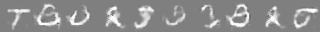

Acc: T [[[0.0015012]]] F [[[0.00314698]]]
Epoch_id: 5 Batch id: 0 	Loss: T  0.0015075151 F 6.828459


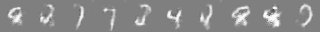

Acc: T [[[0.00331354]]] F [[[0.0011907]]]
Epoch_id: 5 Batch id: 400 	Loss: T  0.003352589 F 7.6879044


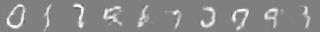

Acc: T [[[0.02157474]]] F [[[0.00036717]]]
Epoch_id: 6 Batch id: 0 	Loss: T  0.02314697 F 9.078993


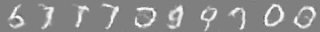

Acc: T [[[0.01385581]]] F [[[0.02001627]]]
Epoch_id: 6 Batch id: 400 	Loss: T  0.014394065 F 4.828823


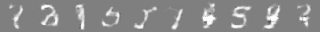

Acc: T [[[0.00575793]]] F [[[0.01543788]]]
Epoch_id: 7 Batch id: 0 	Loss: T  0.0061583174 F 4.6693974


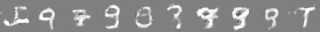

Acc: T [[[0.03415304]]] F [[[0.0166596]]]
Epoch_id: 7 Batch id: 400 	Loss: T  0.036061577 F 4.5454836


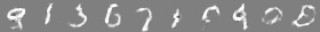

Acc: T [[[0.00946015]]] F [[[0.01133689]]]
Epoch_id: 8 Batch id: 0 	Loss: T  0.009641357 F 5.3435097


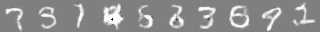

Acc: T [[[0.0022527]]] F [[[4.1756237e-05]]]
Epoch_id: 8 Batch id: 400 	Loss: T  0.002267261 F 11.660242


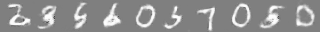

Acc: T [[[0.00674385]]] F [[[0.00276777]]]
Epoch_id: 9 Batch id: 0 	Loss: T  0.0067989533 F 6.804991


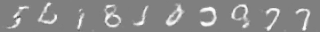

Acc: T [[[0.00937772]]] F [[[0.01461984]]]
Epoch_id: 9 Batch id: 400 	Loss: T  0.009524861 F 4.7555017


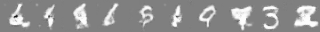

In [9]:

import os
from IPython.display import display

import numpy as np
import torch
from torch import nn
from PIL import Image

from gan.reader import MNISTReader
from gan.net import GenerateNet, DiscriminatorNet, init_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义超参数
EPOCH = 10
BATCH_SIZE = 128

# 定义几个输出目录
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

# 获取数据读取器
loader = torch.utils.data.DataLoader(
    MNISTReader(noise=True, root='~/Datasets/MNIST'),
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True)

# 新建一个生成网络和判别网络
g_net = GenerateNet()
d_net = DiscriminatorNet()

# 对两组网络做一次特殊的初始化（可以不做，效果可能会略差一点）
g_net.apply(init_weights)
d_net.apply(init_weights)
g_net.to(device)
d_net.to(device)

# 定义两组优化器，一组负责更新判别器，另一组负责更新生成器
opt_g = torch.optim.Adam(lr=0.0002, params=g_net.parameters(), betas=(0.5, 0.999))
opt_d = torch.optim.Adam(lr=0.0002, params=d_net.parameters(), betas=(0.5, 0.999))

bce = nn.BCELoss()

for epoch_id in range(EPOCH):
    for batch_id, (b_img, b_noise) in enumerate(loader):
        # Batch ID, 真实的图像, 随机Z向量[N, 100, 1, 1, 1]
        opt_d.zero_grad()
        # 先使用判别器对 真实 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_true_result = d_net(b_img.to(device))
        # 计算判断的结果距离判断为“真”的损失
        loss_true = bce(dis_true_result, torch.ones_like(dis_true_result))
        # 构建相关梯度
        loss_true.backward()

        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise.to(device))
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img.detach())
        # 计算判断的结果距离判断为“假”的损失
        loss_fake = bce(dis_fake_result, torch.zeros_like(dis_fake_result))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_d.step()
        opt_d.zero_grad()

        opt_g.zero_grad()
        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise.to(device))
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img)
        # 为了让生成器生成的数据更加真实，那么我们就要计算生成器生成效果与为“真”的距离
        loss_fake = bce(dis_fake_result, torch.ones_like(dis_true_result))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_g.step()
        opt_g.zero_grad()

        # 每几组数据展示一下效果
        if batch_id % 400 == 0:
            print("Acc: T",
                  (BATCH_SIZE - sum(dis_true_result.cpu().detach().numpy())) / BATCH_SIZE,
                  "F", sum(dis_fake_result.cpu().detach().numpy()) / BATCH_SIZE)
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: T ", loss_true.cpu().detach().numpy(), "F", loss_fake.cpu().detach().numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.cpu().detach().numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)
    torch.save(g_net.state_dict(), MODEL_PATH + f"/GEN_{epoch_id}")
    torch.save(d_net.state_dict(), MODEL_PATH + f"/DIS_{epoch_id}")


# 任务二
提取隐藏因子，搭建出一个“图片->Z向量”的模型。

使其可以输入一张确定的图片，根据该图片来产出一个Z向量，用该Z向量传入根据1中完成的生成模型，使其可以生成出和刚刚输入的确定图片一样的风格。

目的：得到出一个可自行控制的生成模型。

Epoch_id: 0 Batch id: 0 	Loss:  0.046945527


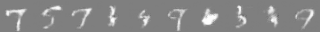

Epoch_id: 0 Batch id: 400 	Loss:  0.008248588


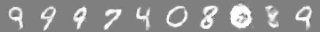

Epoch_id: 1 Batch id: 0 	Loss:  0.007642776


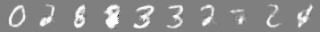

Epoch_id: 1 Batch id: 400 	Loss:  0.0074000377


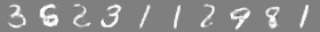

Epoch_id: 2 Batch id: 0 	Loss:  0.0065381555


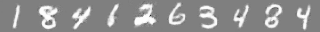

Epoch_id: 2 Batch id: 400 	Loss:  0.0055435905


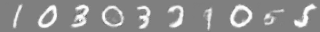

Epoch_id: 3 Batch id: 0 	Loss:  0.0058967904


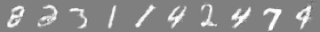

Epoch_id: 3 Batch id: 400 	Loss:  0.0057837195


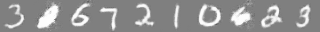

Epoch_id: 4 Batch id: 0 	Loss:  0.005734777


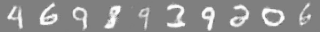

Epoch_id: 4 Batch id: 400 	Loss:  0.005079087


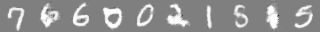

Epoch_id: 5 Batch id: 0 	Loss:  0.0051506655


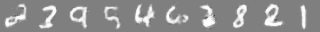

Epoch_id: 5 Batch id: 400 	Loss:  0.0041323267


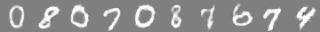

Epoch_id: 6 Batch id: 0 	Loss:  0.005110042


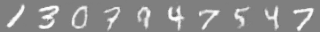

Epoch_id: 6 Batch id: 400 	Loss:  0.004439172


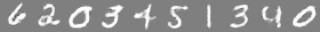

Epoch_id: 7 Batch id: 0 	Loss:  0.005268012


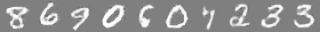

Epoch_id: 7 Batch id: 400 	Loss:  0.0045580384


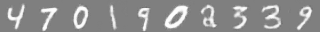

Epoch_id: 8 Batch id: 0 	Loss:  0.0044095577


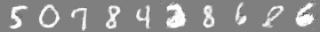

Epoch_id: 8 Batch id: 400 	Loss:  0.0041724397


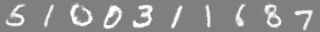

Epoch_id: 9 Batch id: 0 	Loss:  0.004020349


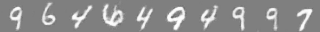

Epoch_id: 9 Batch id: 400 	Loss:  0.004453481


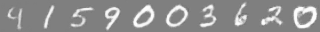

In [10]:

import os

import numpy as np
from PIL import Image

import torch
from torch import nn

from gan.reader import MNISTReader
from gan.net import GenerateNet, MatchingNet, init_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCH = 10
BATCH_SIZE = 128
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

loader = torch.utils.data.DataLoader(
#     MNISTReader(noise=True), 
    MNISTReader(noise=True, root='/hy-tmp/Datasets/MNIST'), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True)

g_net = GenerateNet()
m_net = MatchingNet()
m_net.apply(init_weights)

g_net.to(device)
m_net.to(device)

g_params = torch.load(MODEL_PATH + "/GEN_9")

opt = torch.optim.Adam(lr=0.0002, params=m_net.parameters())

sm1 = nn.SmoothL1Loss()

for epoch_id in range(EPOCH):
    for batch_id, (b_img, _) in enumerate(loader):
        # 使用Z向量生成网络，输入真实图像然后生成Z [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 100, 1, 1]
        b_noise = m_net(b_img.to(device))
        # 此处可以考虑冻结相关参数，赋值法简单但影响运行效率
        g_net.load_state_dict(g_params)
        # 使用生成的Z，传入生成网络 [N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise)

        # 缩小到16x16而非32x32，16也算是做了个平滑，可考虑使用性能更好的lpips来计算相关损失
#         loss_p2p = sm1(nn.functional.upsample(gen_img, size=[16, 16]),
#                        nn.functional.upsample(b_img, size=[16, 16]))
        loss_p2p = sm1(gen_img.to(device), b_img.to(device))
        loss_p2p.backward()
        opt.step()
        opt.zero_grad()

        if batch_id % 400 == 0:
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: ", loss_p2p.cpu().detach().numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.cpu().detach().numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)

    torch.save(m_net.state_dict(), MODEL_PATH + f"/M_{epoch_id}")


# 任务三
输入一张图片，使其可以生成该图片相关风格的数据。

目的：尝试生成出自己喜欢的数字（7），为后续StyleGAN的人像编辑做准备。

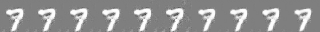

看，这些数字7是不一样的，我们可以在基础的7上生成相似数字的图片


In [11]:

import os

import numpy as np
from PIL import Image

import torch
from torch import nn

from gan.reader import transform
from gan.net import GenerateNet, MatchingNet

INPUT_IMAGE_PATH = "src/7.jpg"
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
MAT_EPOCH = 9
GEN_EPOCH = 9

# 实例化图片生成网络和Z向量生成网络，并加载权重
g_net = GenerateNet()
m_net = MatchingNet()

m_params = torch.load(MODEL_PATH + f"/M_{MAT_EPOCH}")
g_params = torch.load(MODEL_PATH + f"/GEN_{GEN_EPOCH}")

g_net.load_state_dict(g_params)
m_net.load_state_dict(m_params)

# 打开一张数字7的图片
ori_img = Image.open(INPUT_IMAGE_PATH).convert("L")
# ori_img = np.array(ori_img)
ori_img = transform(ori_img).unsqueeze(0)
# ori_img = torch.to_tensor([ori_img.astype("float32")])

def gen(step=0):
    # 使用Z生成网络，基于数字7生成出一个Z向量，并且加入少许随机噪声，方便生成出不一样的图片
    z = m_net(ori_img) + torch.randn([100, 1, 1]) * 0.02 * step
    # 生成图片
    gen_img = g_net(z).detach().numpy()
    return gen_img[0][0]

# 绘制图片
display_img = gen()
for img_id in range(1, 10):
    display_img = np.concatenate([display_img, gen(img_id)], axis=-1)
display_img = (display_img + 1) * 127
im = Image.fromarray(display_img).convert("RGB")
display(im)
print("看，这些数字7是不一样的，我们可以在基础的7上生成相似数字的图片")